In [60]:
import zipfile#biblioteca para manipular arquivos zip
import os#biblioteca para manipular o sistema de arquivos
from PIL import Image#biblioteca para manipulação de imagens
import numpy as np#biblioteca para manipulação de arrays numéricos

#definição do tamanho das imagens e inicialização de listas
IMG_SIZE = 80#tamanho para redimensionar as imagens (80x80 pixels)
categories = []#lista para armazenar as categorias (subdiretórios)
images = []#lista para armazenar as imagens processadas
labels = []#lista para armazenar os rótulos das imagens

#caminho do arquivo zip e do diretório de extração
zip_path = 'C:/Users/lucia/Downloads/data.zip'#caminho do arquivo zip
extract_path = 'C:/Users/lucia/Downloads/data_extracted'#caminho para extrair os arquivos

#verifica se o arquivo zip existe e o extrai
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)#extrai o conteúdo do zip
    print(f"arquivo zip extraído para: {extract_path}")
else:
    print(f"erro: arquivo zip não encontrado: {zip_path}")

#verifica se o diretório extraído existe
if os.path.exists(extract_path):
    data_path = extract_path#define o caminho dos dados extraídos
    categories = os.listdir(data_path)#lista os subdiretórios (categorias)
    print("categorias encontradas:", categories)
else:
    print("erro: diretório extraído não encontrado.")
    categories = []

#processa as imagens se houver pelo menos duas categorias
if len(categories) < 2:
    print("erro: menos de dois subdiretórios encontrados.")
else:
    #define os caminhos para as categorias
    path_rejected = os.path.join(data_path, categories[0])#caminho para a categoria "rejeitado"
    path_approved = os.path.join(data_path, categories[1])#caminho para a categoria "aprovado"

    #lista os arquivos em cada categoria
    rejected = os.listdir(path_rejected)
    approved = os.listdir(path_approved)

    dataset = [rejected, approved]#agrupa as listas de arquivos

    #processa as imagens de cada categoria
    for i in range(len(dataset)):
        for img_path in dataset[i]:
            #abre a imagem, redimensiona e converte para array
            img = Image.open(os.path.join(data_path, categories[i], img_path)).resize((IMG_SIZE, IMG_SIZE))
            img = np.asarray(img)
            images.append(img)#adiciona a imagem processada à lista
            labels.append(i)#adiciona o rótulo correspondente (0 ou 1)

    #converte a lista de imagens para um array numpy e mantém apenas o canal de cinza
    images = np.asarray(images)
    images = images[:, :, :, 0]

    print("imagens processadas:", len(images))

arquivo zip extraído para: C:/Users/lucia/Downloads/data_extracted
categorias encontradas: ['Exportacion', 'Rechazo', 'Referencia.txt']
imagens processadas: 980


(980, 80, 80)


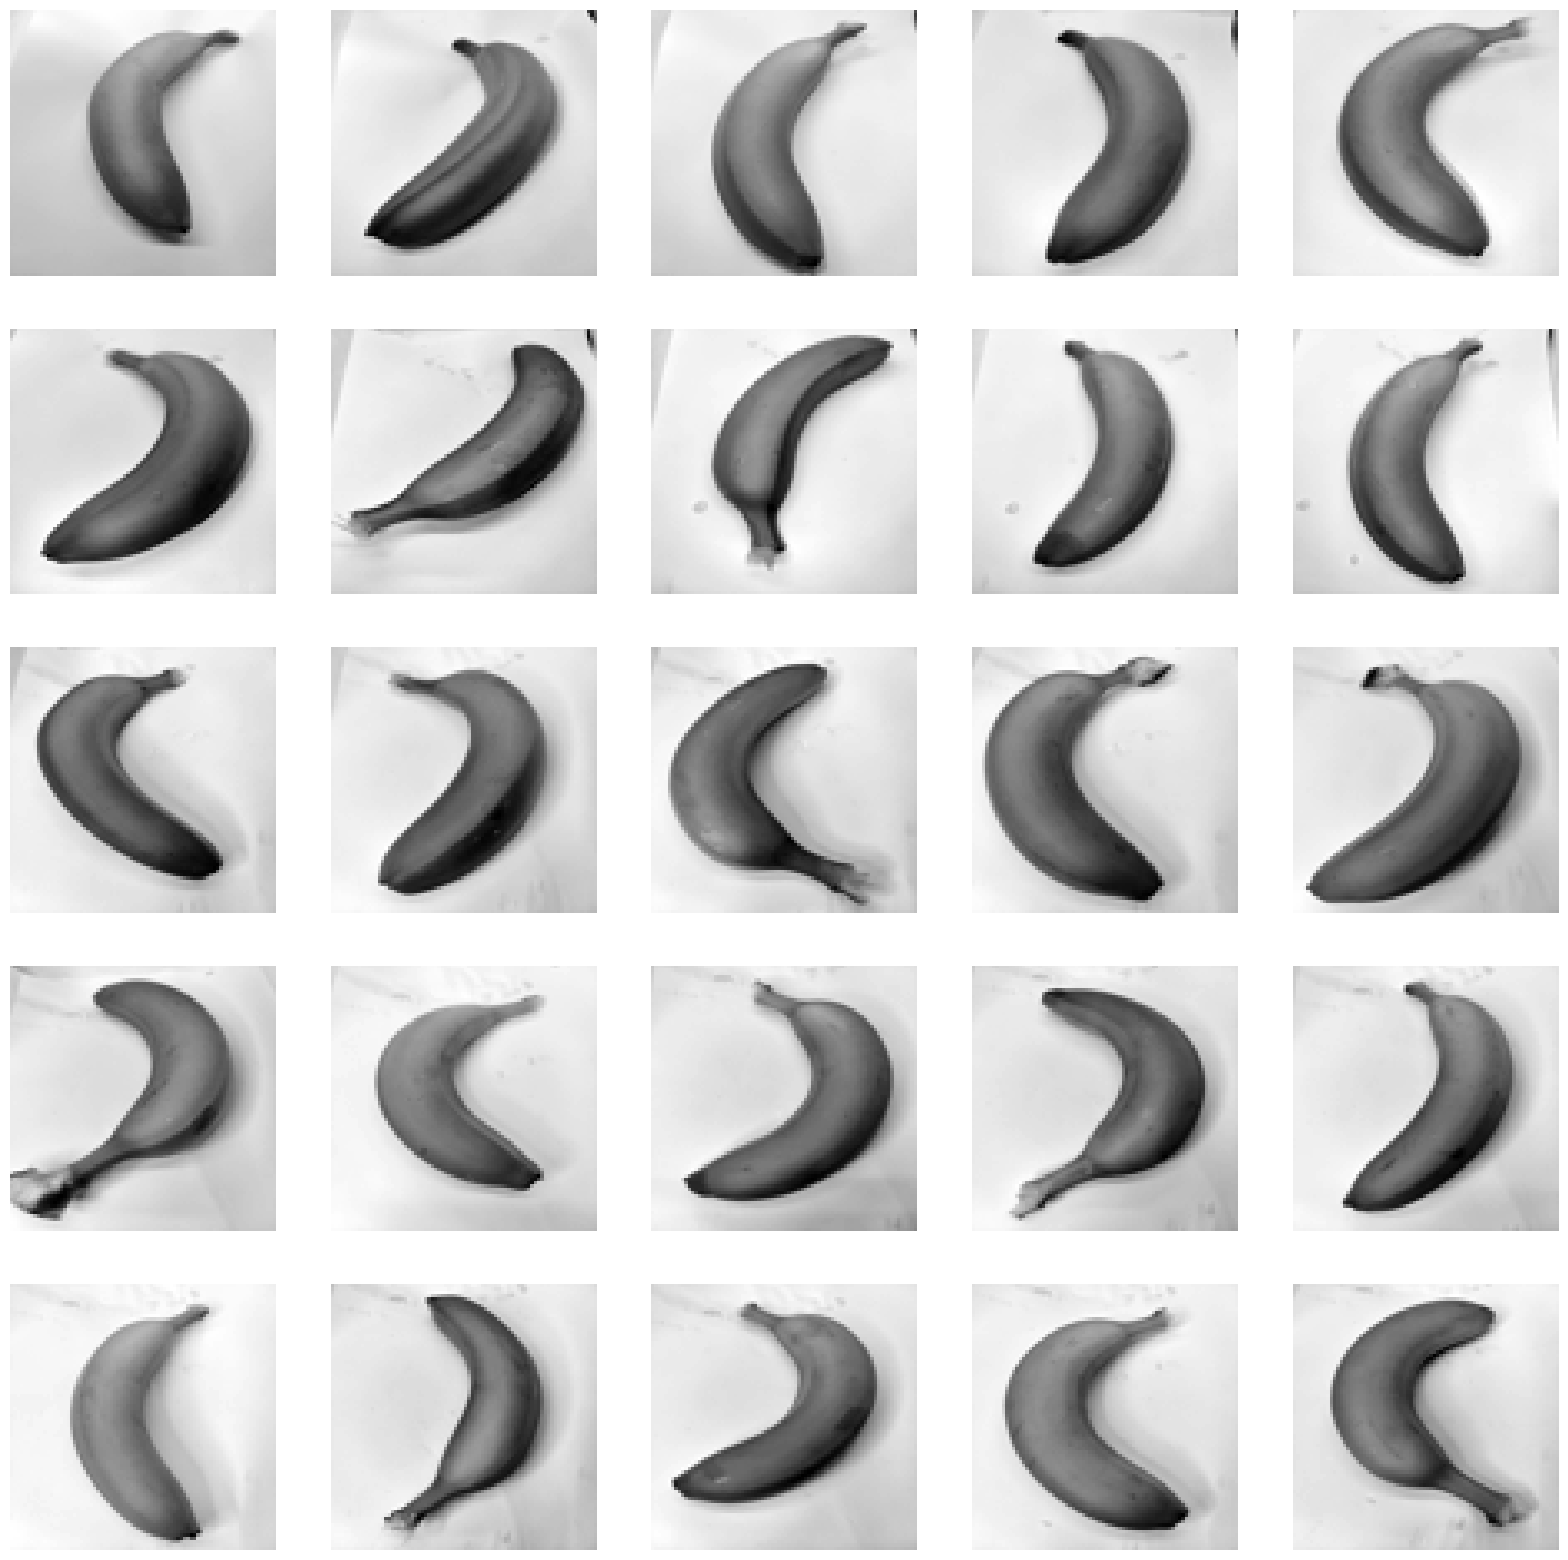

In [61]:
#visualiza as primeiras 25 imagens processadas
import matplotlib.pyplot as plt#biblioteca para visualização de gráficos

plt.figure(figsize=(20, 20))
print(images.shape)
for i, img in enumerate(images[0:25]):
    plt.subplot(5, 5, i + 1)#cria uma grade 5x5 para as imagens
    plt.imshow(img, cmap='gray')#exibe a imagem em escala de cinza
    plt.axis('off')#remove os eixos para uma visualização mais limpa
plt.show()#exibe todas as imagens


In [62]:
#prepara os dados de treinamento
training_data = []
for img in images:
    img = img.reshape(IMG_SIZE, IMG_SIZE, 1)#redimensiona para incluir o canal de cor
    training_data.append(img)

In [63]:
#normaliza os dados para valores entre 0 e 1
training_data = np.array(training_data).astype(float) / 255
labels = np.array(labels)#converte os rótulos para array NumPy

In [64]:
print(len(labels))
print(training_data.shape)

980
(980, 80, 80, 1)


# Increasing Data

In [65]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

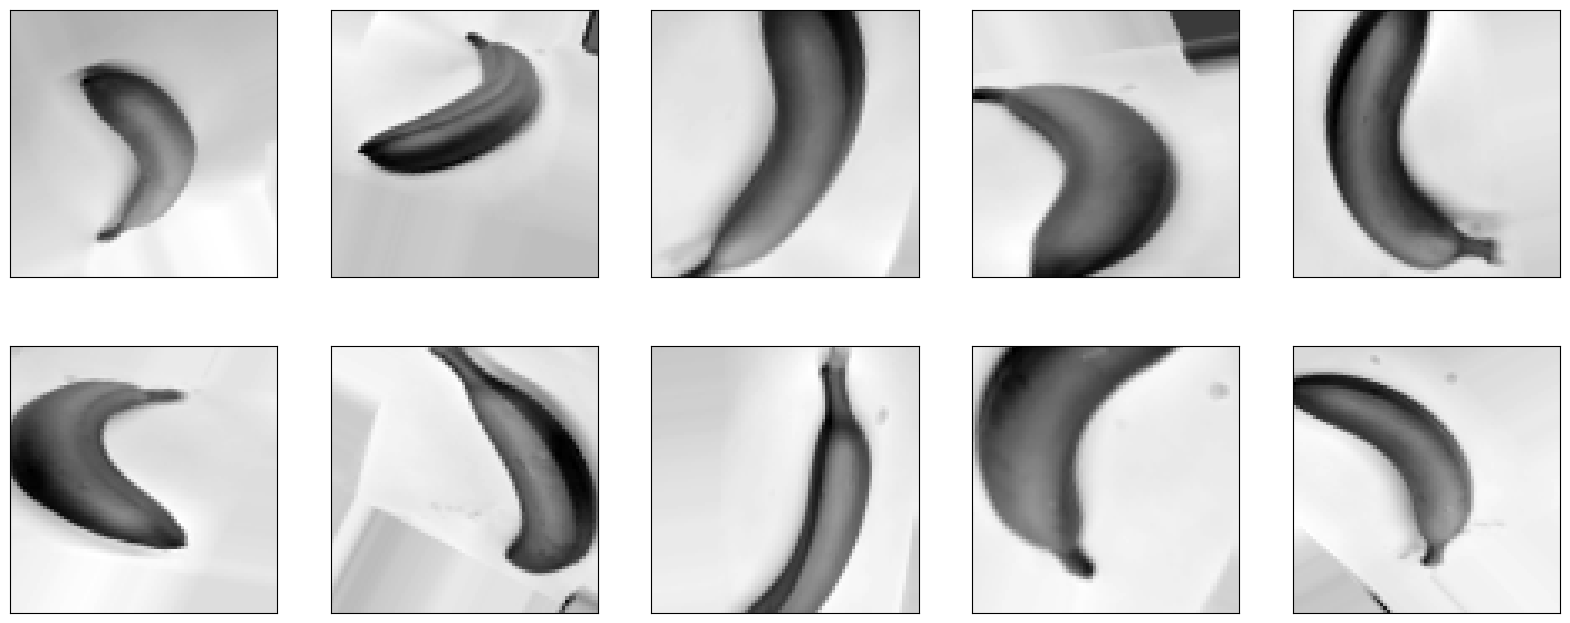

In [66]:
datagen = ImageDataGenerator(
    rotation_range=30,#rotação aleatória de até 30 graus
    width_shift_range=0.2,#deslocamento horizontal
    height_shift_range=0.2,#deslocamento vertical
    shear_range=15,#transformação de cisalhamento
    zoom_range=[0.7, 1.4],#zoom aleatório
    horizontal_flip=True,#espelhamento horizontal
    vertical_flip=True#espelhamento vertical
)

datagen.fit(training_data)#ajusta o gerador aos dados de treinamento

#visualiza algumas imagens aumentadas
plt.figure(figsize=(20, 8))
for imagen, etiqueta in datagen.flow(training_data, labels, batch_size=10, shuffle=False):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imagen[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    break

In [67]:
#divide os dados em treinamento e validação
training_d = training_data[:830]
validation_d = training_data[830:]

training_l = labels[:830]
validation_l = labels[830:]


In [68]:
#configura o gerador de dados para treinamento
BATCH_SIZE = 16
data_gen_training = datagen.flow(training_d, training_l, batch_size=BATCH_SIZE)

# Creating Models

In [69]:
convModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),#primeira camada convolucional
    tf.keras.layers.MaxPooling2D(2, 2),#primeira camada de pooling
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),#segunda camada convolucional
    tf.keras.layers.MaxPooling2D(2, 2),#segunda camada de pooling
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),#terceira camada convolucional
    tf.keras.layers.MaxPooling2D(2, 2),#terceira camada de pooling
    tf.keras.layers.Dropout(0.5),#camada de dropout para evitar overfitting
    tf.keras.layers.Flatten(),#achata os dados para entrada na camada densa
    tf.keras.layers.Dense(250, activation='relu'),#camada densa intermediária
    tf.keras.layers.Dense(1, activation='sigmoid')#camada de saída com ativação sigmoide (classificação binária)
])

In [70]:
#compila o modelo
convModel.compile(optimizer='Adam',#otimizador Adam
                  loss='binary_crossentropy',#função de perda para classificação binária
                  metrics=['accuracy'])#métrica de avaliação: acurácia

In [71]:
import numpy as np

#supondo que training_data e labels já estejam definidos
training_data = np.array(training_data)
labels = np.array(labels)

#truncar training_data para ter o mesmo número de amostras que labels
min_samples = min(len(training_data), len(labels))
training_data = training_data[:min_samples]
labels = labels[:min_samples]

#treine o modelo
modelo = convModel.fit(training_data, labels,
                        batch_size=10,
                        validation_split=0.15,
                        epochs=25)

Epoch 1/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5682 - loss: 0.6816 - val_accuracy: 0.0952 - val_loss: 1.0665
Epoch 2/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7120 - loss: 0.5539 - val_accuracy: 0.5034 - val_loss: 0.7601
Epoch 3/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8332 - loss: 0.4024 - val_accuracy: 0.5238 - val_loss: 1.0038
Epoch 4/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8901 - loss: 0.3452 - val_accuracy: 0.3469 - val_loss: 1.6508
Epoch 5/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9007 - loss: 0.2767 - val_accuracy: 0.8571 - val_loss: 0.3042
Epoch 6/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8497 - loss: 0.3796 - val_accuracy: 0.8435 - val_loss: 0.4782
Epoch 7/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9117 - loss: 0.2267 - val_accuracy: 0.4830 - val_loss: 1.1728
Epoch 8/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9247 - loss: 0.2165 - val_accuracy: 0.8163 - v

In [72]:
import numpy as np

#supondo que validation_d e validation_l já estejam definidos
validation_d = np.array(validation_d)
validation_l = np.array(validation_l)

#truncar validation_d para ter o mesmo número de amostras que validation_l
min_samples = min(len(validation_d), len(validation_l))
validation_d = validation_d[:min_samples]
validation_l = validation_l[:min_samples]

#treine o modelo
modelo = convModel.fit(data_gen_training, epochs=50, batch_size=BATCH_SIZE,
                       validation_data=(validation_d, validation_l),
                       steps_per_epoch=int(np.ceil(len(training_d) / float(32))),
                       validation_steps=int(np.ceil(len(validation_d) / float(32))),
                      )

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6360 - loss: 1.1036 - val_accuracy: 0.1000 - val_loss: 0.9659
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6441 - loss: 0.6373 - val_accuracy: 0.0250 - val_loss: 1.1176
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6491 - loss: 0.6193 - val_accuracy: 0.1250 - val_loss: 1.2728
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6943 - loss: 0.5846 - val_accuracy: 0.2500 - val_loss: 1.1366
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.7558 - loss: 0.5215 - val_accuracy: 0.4125 - val_loss: 0.9051
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7493 - loss: 0.5361 - val_accuracy: 0.7750 - val_loss: 0.5128
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7066 - loss: 0.5976 - val_accuracy: 0.3000 - val_loss: 0.9769
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7629 - loss: 0.5175 - val_accuracy: 0.7875 - v

# Checking Model

Text(0.5, 1.0, 'Val accuracy')

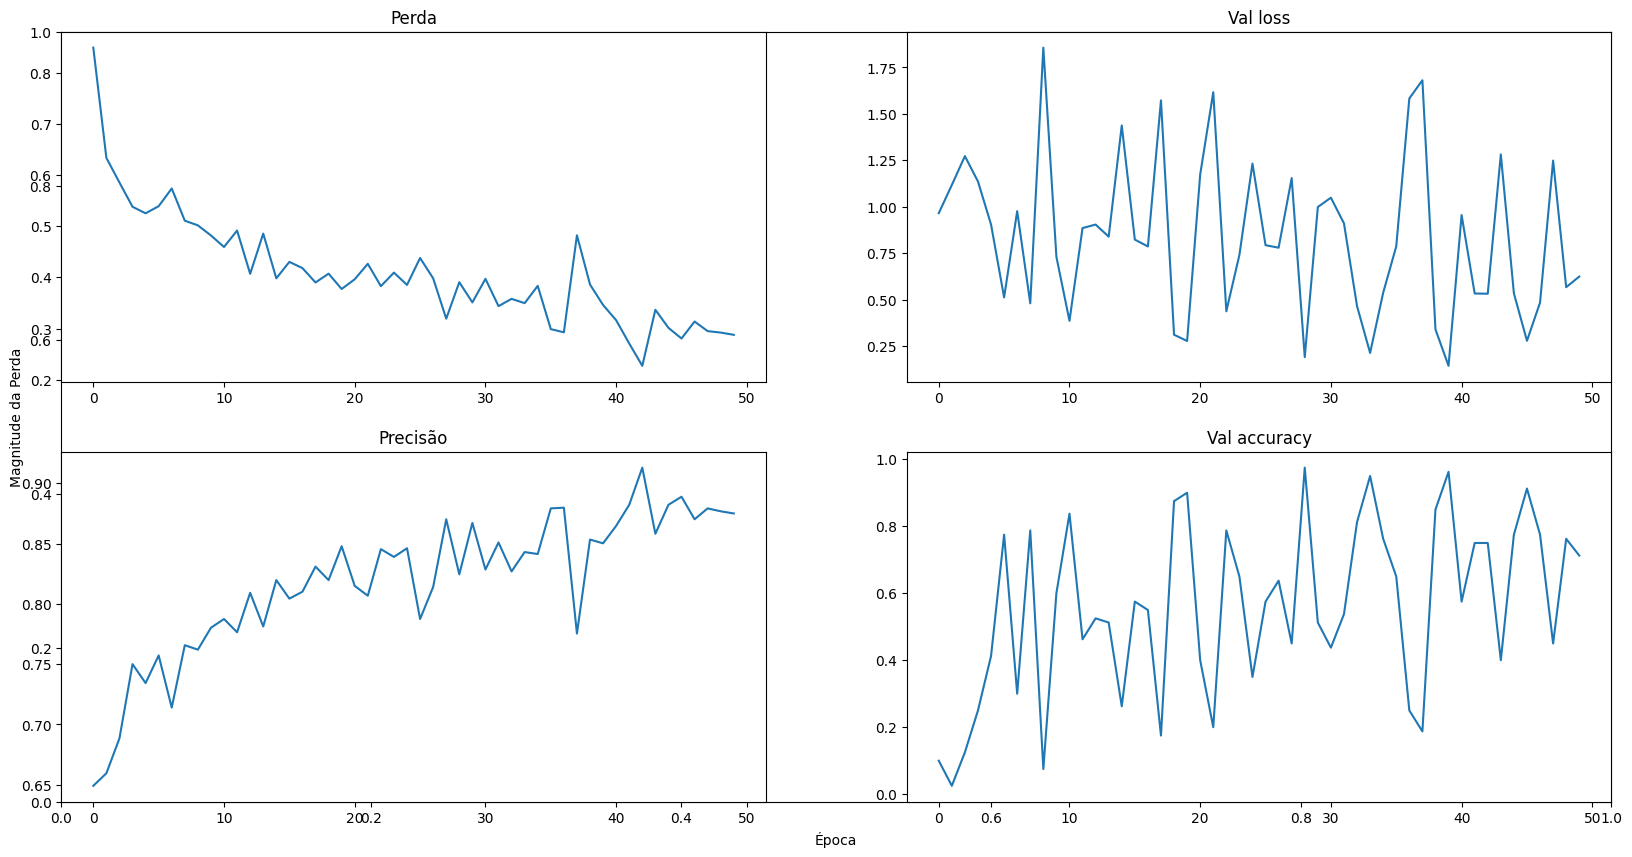

In [ ]:
#visualiza as métricas de treinamento
plt.figure(figsize=(20, 10))
plt.xlabel('Época')
plt.ylabel("Magnitude da Perda")
model_loss = plt.subplot(2, 2, 1)
model_loss.plot(modelo.history['loss'])
model_loss.set_title("Perda")
model_val_loss = plt.subplot(2, 2, 2)
model_val_loss.plot(modelo.history['val_loss'])
model_val_loss.set_title("Val Perda")
model_accuracy = plt.subplot(2, 2, 3)
model_accuracy.plot(modelo.history['accuracy'])
model_accuracy.set_title("Precisão")
model_val_accuracy = plt.subplot(2, 2, 4)
model_val_accuracy.plot(modelo.history['val_accuracy'])
model_val_accuracy.set_title("Val Precisão")

# Testing Model

In [74]:
import random

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


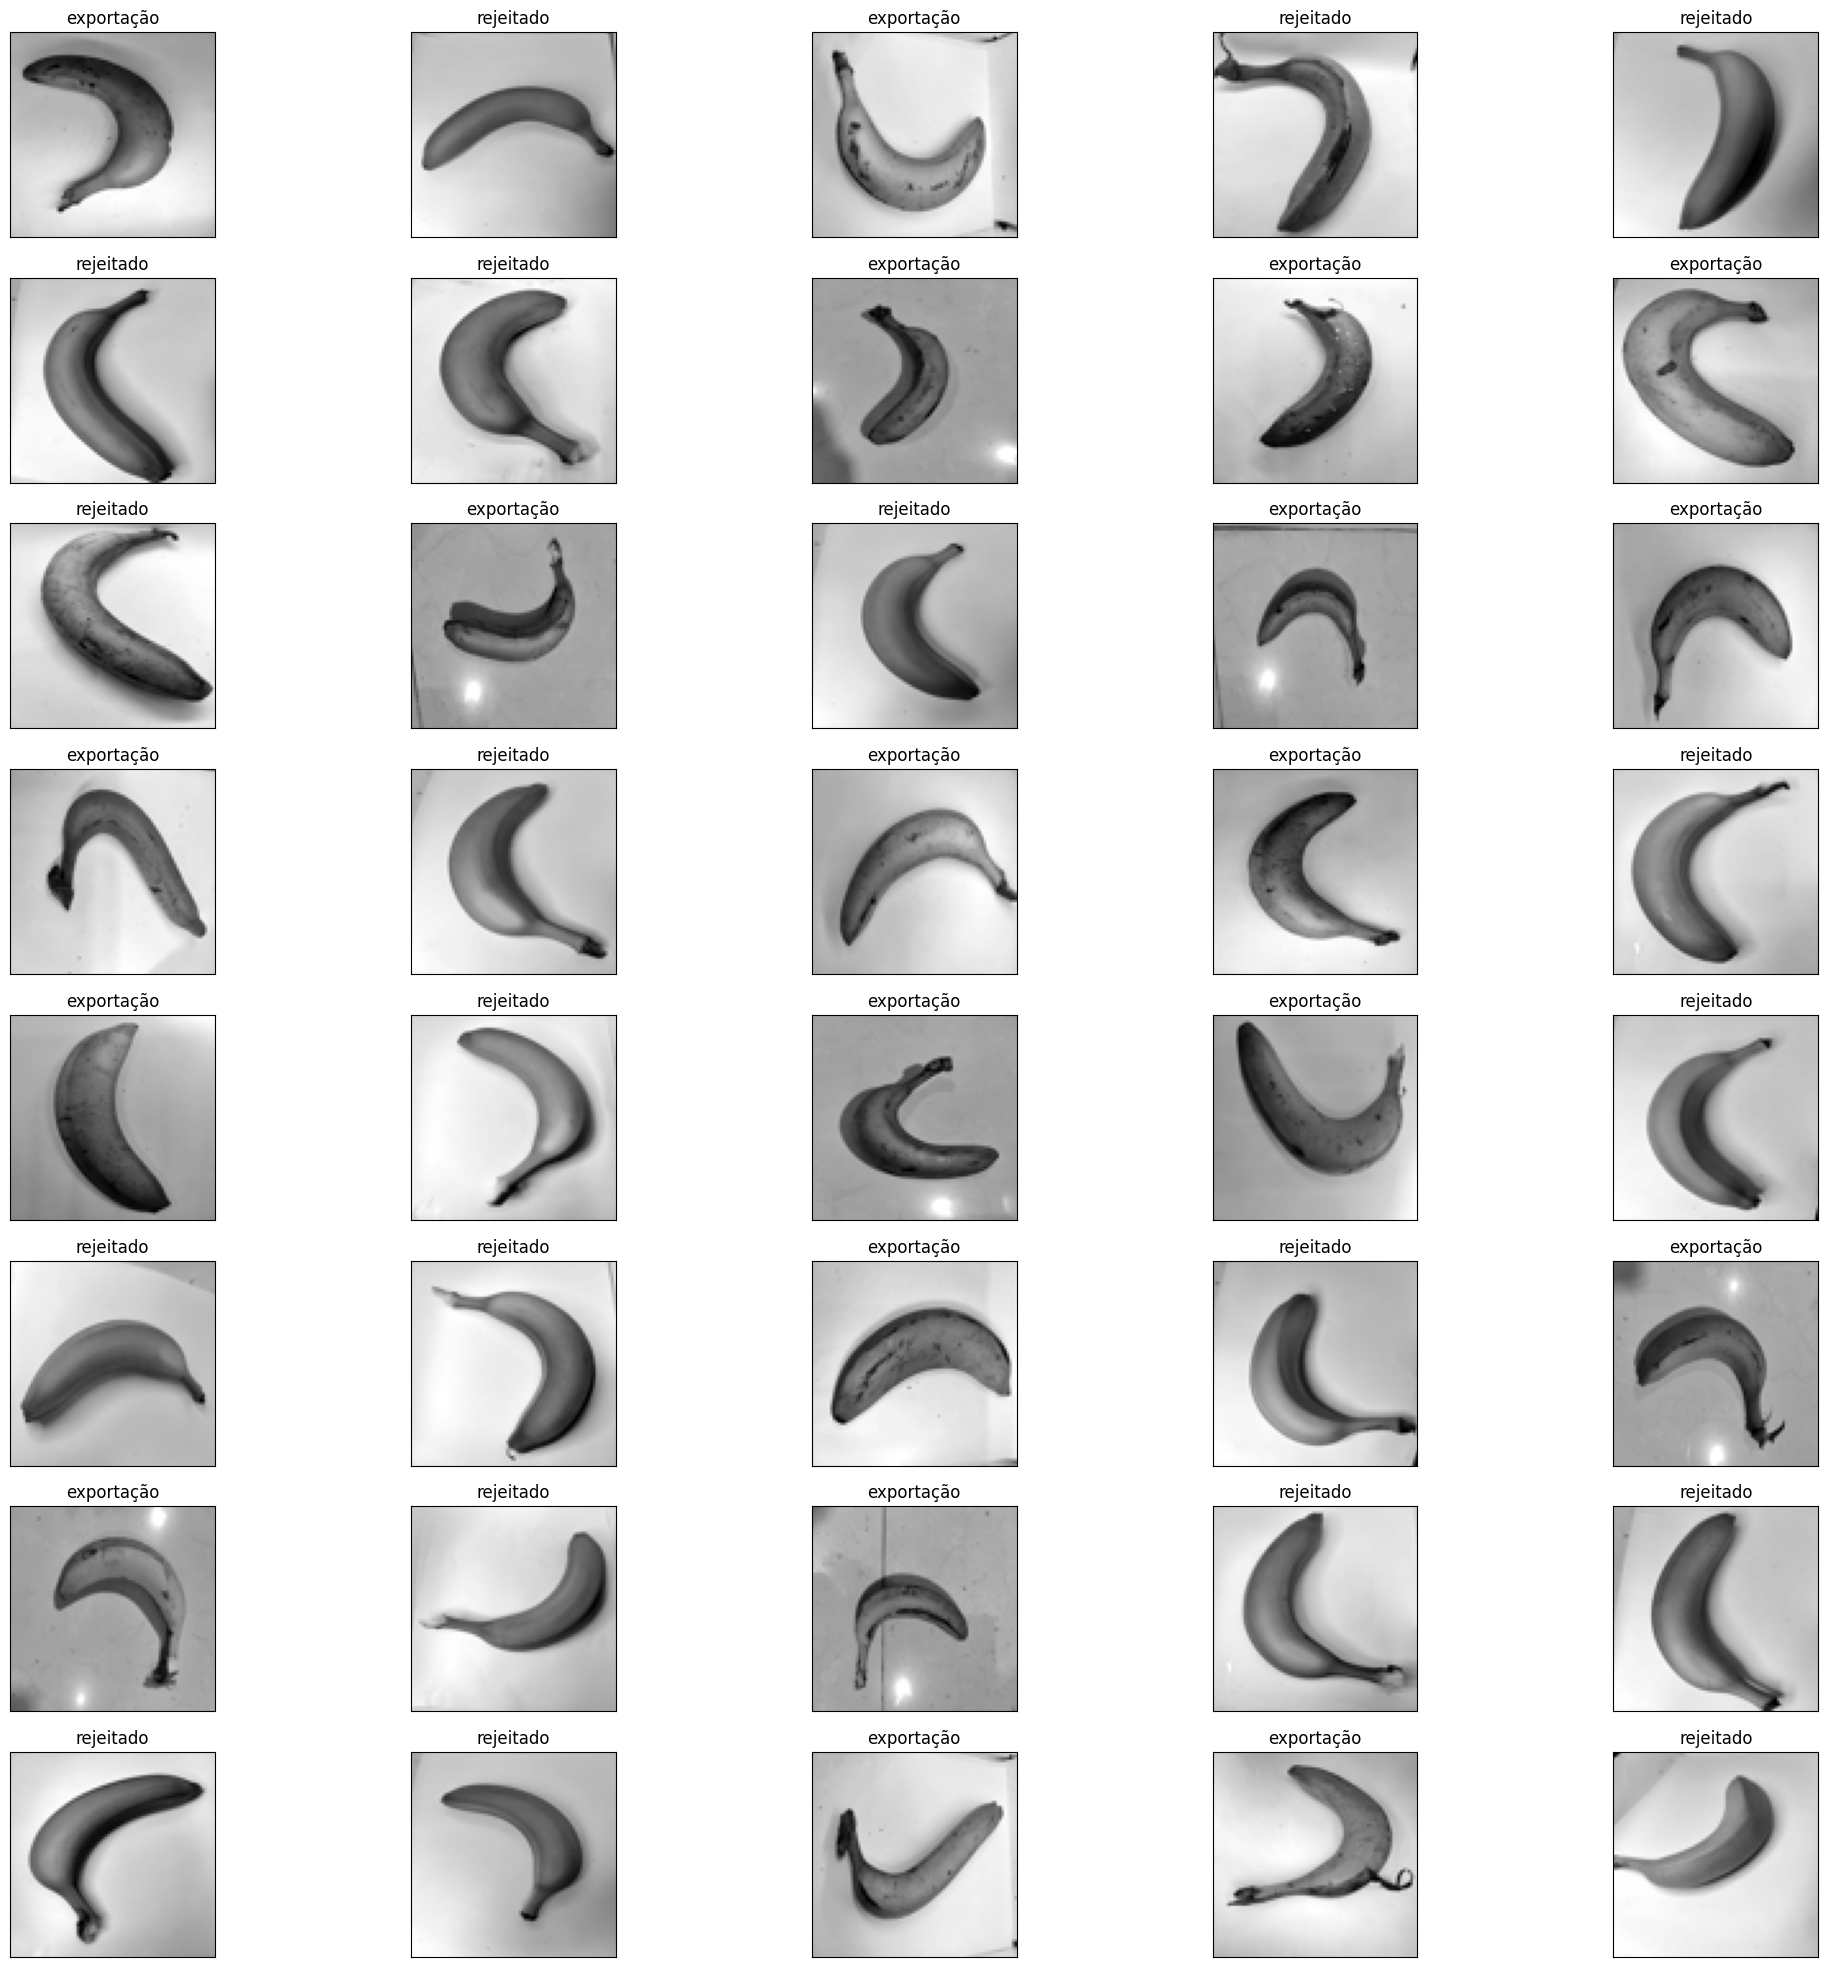

In [75]:
testing_data = random.sample(list(training_data), 40)#seleciona 40 imagens aleatórias
predictions = convModel.predict(np.asarray(testing_data))#faz previsões
plt.figure(figsize=(25, 25))
for i, prediction in enumerate(predictions):
    img_plot = plt.subplot(8, 5, i + 1)
    plt.imshow(testing_data[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    label = 'rejeitado'#define o rótulo como "rejeitado" por padrão
    if prediction > 0.5:#se a previsão for maior que 0.5, altera para "exportação"
        label = 'exportação'
    img_plot.set_title(label)